In [1]:
import sys
sys.path.append('..')
sys.path.append('../src')

from src.agent.CRAR  import CRAR 
from omegaconf import OmegaConf
from src.envs import SimpleMazeEnv
# from utils.logger import PlatformLogger
import os 
import torch 
import numpy as np 
from copy import deepcopy

In [2]:
def eval(env_class, agent, flags, obs_preprocessing):
    env = env_class()

    flags.random_action = True
    agent_eps = agent.epsilon
    agent.epsilon = flags.test_epsilon 
    rewards = [0 for i in range(flags.test_episodes)]
    
    states = []

    done = False 
    timestep = 0 
    state = env.reset()
    while True:
        act = agent.act(obs_preprocessing(torch.tensor(state, device=flags.device)).unsqueeze(0))
        ns, reward, done, info = env.step(act)
        rewards[0] += reward
        timestep += 1

        flag = True
        for s in states:
            if (ns == s).all():
                flag = False
        if flag:
            states.append(deepcopy(ns))
        
        if len(states) == 31:
            break
            
    info_dict = {
        "timestep": float(timestep),
        "return_mean" : float(np.mean(rewards)),
        "return_median" : float(np.median(rewards)),
        "return_var" : float(np.var(rewards))
    }
    print(info_dict)
    agent.epsilon = agent_eps

    return states

In [3]:
ckpt_path = "../results/22-06-17/11-34-06"

In [4]:
flags = OmegaConf.load(os.path.join(ckpt_path, f"config.yaml"))
# logger = PlatformLogger(RESULT_path)
dummy_env = SimpleMazeEnv()
agent = CRAR(dummy_env.observation_space, dummy_env.action_space, flags, logger=None)
agent.load(os.path.join(ckpt_path, f"checkpoint.tar"))

In [5]:
obs_preprocessing = lambda x : x.unsqueeze(0)

states = eval(SimpleMazeEnv, agent, flags, obs_preprocessing)

{'timestep': 394.0, 'return_mean': 0.0, 'return_median': 0.0, 'return_var': 0.0}


In [6]:
from collections import defaultdict
from torch import nn

X = defaultdict(list)

for state in states:
    encoded_state = agent.encoder(obs_preprocessing(torch.tensor(state, device=flags.device)).unsqueeze(0))
    X['node'].append(encoded_state.detach().cpu().numpy())
    for action in [0, 1, 2, 3]:
        onehot_action = nn.functional.one_hot(torch.tensor([action], device=flags.device).long(), dummy_env.action_space.n).squeeze(1)
        transition_pred = agent.transition_net(torch.cat((encoded_state, onehot_action), 1))
        X['transition_'+str(action)].append(transition_pred.detach().cpu().numpy())
        # X['transition_'+str(action)].append((encoded_state+transition_pred).detach().cpu().numpy())

/data2/cwkang/anaconda3/envs/pybullet_gym/lib/python3.8/site-packages/torch/nn/modules/conv.py:443: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:744.)
  return F.conv2d(input, weight, bias, self.stride,


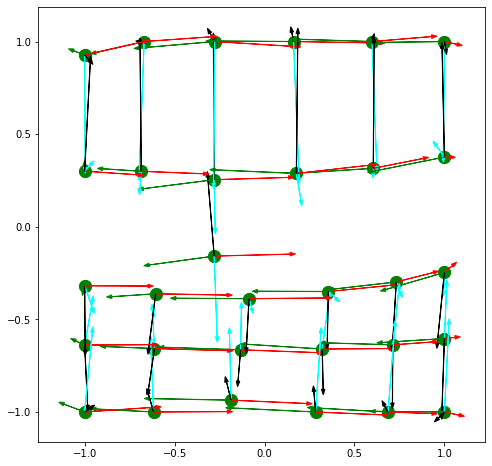

In [7]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,8))

# draw nodes
x, y = defaultdict(list), defaultdict(list)
for point in X['node']:
    x_, y_ = point[0]
    x['node'].append(x_)
    y['node'].append(y_)
plt.scatter(x['node'], y['node'], marker='o', s=150, c='green')

# draw edges
color_map = ['red', 'green', 'cyan', 'black']
for i in range(len(X['node'])):
    for j in range(4):
        if j == 0 or True:
            plt.arrow(x['node'][i], y['node'][i], X['transition_'+str(j)][i][0][0], X['transition_'+str(j)][i][0][1], color=color_map[j], head_width=0.02)
        # plt.plot([x['node'][i], X['transition_'+str(j)][i][0][0]], [y['node'][i], X['transition_'+str(j)][i][0][1]], color=color_map[j])

plt.show()
